In [1]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# 1. Read Data


In [2]:
df=pd.read_csv('prices.csv')
df1=df[df['symbol']=='AMZN']
df1.head()

,date,symbol,open,close,low,high,volume
284,2010-01-04,AMZN,136.250000,133.899994,133.139999,136.610001,7599900.0
751,2010-01-05,AMZN,133.429993,134.690002,131.809998,135.479996,8851900.0
1219,2010-01-06,AMZN,134.600006,132.250000,131.649994,134.729996,7178800.0
1687,2010-01-07,AMZN,132.009995,130.000000,128.800003,132.320007,11030200.0
2155,2010-01-08,AMZN,130.559998,133.520004,129.029999,133.679993,9830500.0


In [3]:
# drop the categorical data 
df1.drop(['symbol'], axis=1, inplace=True)
"""
We have total around 6 years of data
"""
df1['date']=pd.to_datetime(df1['date'])
print("Minimum date value : {}".format(df1['date'].min()))
print("Maximum date value : {}".format(df1['date'].max()))

Minimum date value : 2010-01-04 00:00:00
Maximum date value : 2016-12-30 00:00:00


In [4]:
df1.describe()

,open,close,low,high,volume
count,1762.000000,1762.000000,1762.000000,1762.000000,1.762000e+03
mean,337.875664,337.899058,333.969688,341.464438,4.607596e+06
std,189.294231,189.109339,187.654696,190.525796,3.091557e+06
min,105.930000,108.610001,105.800003,111.290001,9.844000e+05
25%,192.962494,193.377506,190.284997,195.532501,2.741550e+06
50%,282.500000,282.915008,279.869995,285.074997,3.890700e+06
75%,398.425003,398.014999,393.799988,402.082496,5.384450e+06
max,845.789978,844.359985,840.599976,847.210022,4.242110e+07


In [5]:
# closing price is the target, 
# we calculates the correlation between input features 
# with closing price: 
df1.corr()['close']

open      0.999581
close     1.000000
low       0.999832
high      0.999811
volume   -0.238560
Name: close, dtype: float64

# 2. Train Test Split


In [6]:
from sklearn.model_selection import train_test_split

X=df1[['open','low','high','volume']]
y=df1['close']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, shuffle=False, random_state=42)

# Normalizing the values
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test =scaler.transform(X_test)

# 3. Apply linear regression model


Text(800000, 560, 'Mean Squared error : 11.04')

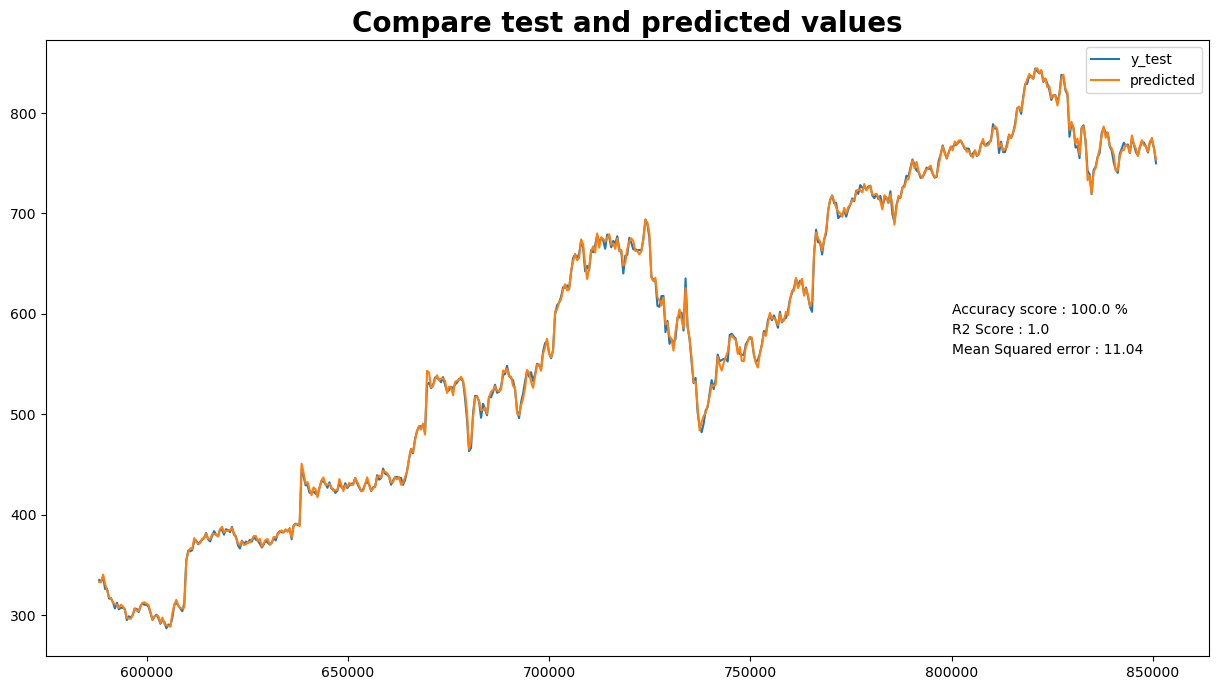

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn import set_config

# train the model 
model = LinearRegression()
model.fit(X_train,y_train)
pred=model.predict(X_test)

# display the results  
set_config(display='diagram')
sc=np.round(model.score(X_test, y_test),2) * 100
r2=np.round(r2_score(y_test,pred),2)
mse=np.round(mean_squared_error(y_test,pred),2)

fig=plt.figure(figsize=(15,8))
p=pd.Series(pred, index=y_test.index)
plt.plot(y_test)
plt.plot(p)
plt.legend(['y_test','predicted'])
plt.title("Compare test and predicted values", size=20, weight='bold')
plt.text(x=800000, y=600,s='Accuracy score : {} %'.format(sc))
plt.text(x=800000, y=580,s='R2 Score : {}'.format(r2))
plt.text(x=800000, y=560,s='Mean Squared error : {}'.format(mse))

# 3. Sensitivity Analysis

## 3.1 Sample dependent inputs

####  Here, we assume that the inputs are dependent with known covariance matrix and follows the normal distribution

In [8]:
"""
Generate the correlated inputs
"""
M = 1000 # the number of samples we will generate
d = 4 # dimension of our input matrix (number of features)

"""
We use known covariance matrix and mean values from the training data.
cov: covariance matrix
mu: mean of each feature
"""
normal_data = pd.concat([np.log(df1['open']), np.log(df1['low']), np.log(df1['high']), np.log(df1['volume'])], axis=1)
cov = [[3.583231e+04,3.551356e+04,3.605965e+04,-1.390693e+08],
[3.551356e+04,3.521428e+04,3.574450e+04,-1.413649e+08],
[3.605965e+04,3.574450e+04,3.630008e+04,-1.374580e+08],
[-1.390693e+08,-1.413649e+08,-1.374580e+08,9.557726e+12]] 
mu = [normal_data['open'].mean(), normal_data['low'].mean(), normal_data['high'].mean(),normal_data['volume'].mean()]

"""
sample normal data based on known mean and variance
"""
xx = np.random.default_rng().multivariate_normal(mu, cov, size=M)
scaler = StandardScaler()
XX = scaler.fit_transform(xx) # generate normal data
np.savetxt('sample_data_dependent.csv', XX, delimiter=',')

## 3.2 Get DerSHAP

time is: 0.1933879852294922


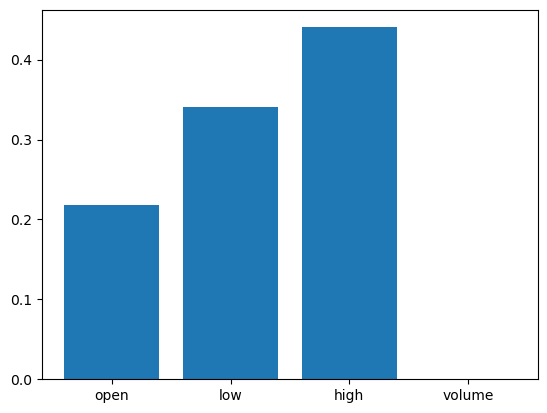

In [9]:
"""
Get the gradient matrix C
"""
import active_subspaces.utils.misc as misc
import active_subspaces as ac
import time

XX = np.loadtxt('sample_data_dependent.csv', delimiter=',')
start = time.time()
df = ac.gradients.finite_difference_gradients(XX, model.predict, h=10e-6)
C = np.dot(df.transpose(), df)
C = abs(C) # take absolute value of matrix C

"""
compute activity scores Shapley
"""

shap = np.zeros(len(C))
for ii in range(len(C)):
    shap[ii] = 0.5*C[ii,ii]
    temp = 0
    for jj in range(len(C[0])):
        temp = 0.5 * C[ii,jj]
    shap[ii] += temp
norm_shap = [shap[ii]/sum(shap) for ii in range(len(shap))]

print("time is:", time.time()-start)

"""
Display the DerSHAP
"""
in_labels=['open','low','high','volume']
plt.bar(in_labels, norm_shap)
plt.savefig("Amazon_DerSHAP.pdf")

## 3.3 Get SHAP

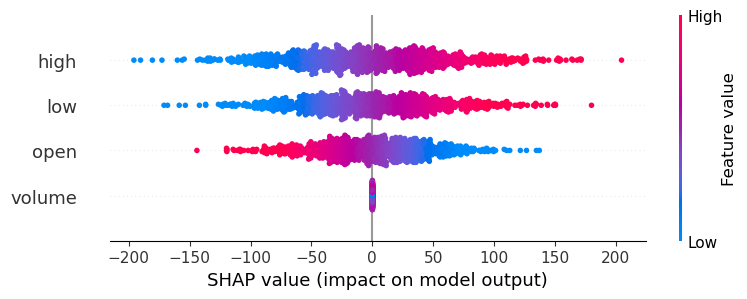

0.22951912879943848


<Figure size 640x480 with 0 Axes>

In [10]:
import shap, time
start = time.time()
XX = np.loadtxt('sample_data_dependent.csv', delimiter=',')
explainer = shap.explainers.Linear(model, X_train)
shap_values = explainer(XX)
shap.summary_plot(shap_values, XX, feature_names=['open','low','high','volume'])
print(time.time()-start)
plt.savefig("Amazon_SHAP.pdf")